In [1]:
import numpy as np
from PIL import Image
import os
import keras 

TUMOR_path = 'Kather_texture_2016_image_tiles_5000/01_TUMOR/'
STROMA_path = 'Kather_texture_2016_image_tiles_5000/02_STROMA/'
COMPLEX_path = 'Kather_texture_2016_image_tiles_5000/03_COMPLEX/'
LYMPHO_path = 'Kather_texture_2016_image_tiles_5000/04_LYMPHO/'
DEBRIS_path = 'Kather_texture_2016_image_tiles_5000/05_DEBRIS/'
MUCOSA_path= 'Kather_texture_2016_image_tiles_5000/06_MUCOSA/'
ADIPOSE_path = 'Kather_texture_2016_image_tiles_5000/07_ADIPOSE/'
EMPTY_path = 'Kather_texture_2016_image_tiles_5000/08_EMPTY/'

#Load the images from each folder path
TUMOR = np.array([np.array(Image.open(TUMOR_path + fname)) for fname in os.listdir(TUMOR_path)])
STROMA = np.array([np.array(Image.open(STROMA_path + fname)) for fname in os.listdir(STROMA_path)])
COMPLEX = np.array([np.array(Image.open(COMPLEX_path + fname)) for fname in os.listdir(COMPLEX_path)])
LYMPHO = np.array([np.array(Image.open(LYMPHO_path + fname)) for fname in os.listdir(LYMPHO_path)])
DEBRIS = np.array([np.array(Image.open(DEBRIS_path + fname)) for fname in os.listdir(DEBRIS_path)])
MUCOSA = np.array([np.array(Image.open(MUCOSA_path + fname)) for fname in os.listdir(MUCOSA_path)])
ADIPOSE = np.array([np.array(Image.open(ADIPOSE_path + fname)) for fname in os.listdir(ADIPOSE_path)])
EMPTY = np.array([np.array(Image.open(EMPTY_path + fname)) for fname in os.listdir(EMPTY_path)])

#Create the labels for each image so we know which image belongs to which class
TUMOR_labels = np.ones((len(TUMOR),1))
STROMA_labels = np.ones((len(STROMA),1))*2
COMPLEX_labels = np.ones((len(COMPLEX),1))*3
LYMPHO_labels = np.ones((len(LYMPHO),1))*4
DEBRIS_labels = np.ones((len(DEBRIS),1))*5
MUCOSA_labels = np.ones((len(MUCOSA),1))*6
ADIPOSE_labels = np.ones((len(ADIPOSE),1))*7
EMPTY_labels = np.ones((len(EMPTY),1))*8

In [2]:
#Combine all the images and labels into one X and y array
X = np.concatenate((TUMOR,STROMA,COMPLEX,LYMPHO,DEBRIS,MUCOSA,ADIPOSE,EMPTY),axis=0)
y = np.concatenate((TUMOR_labels,STROMA_labels,COMPLEX_labels,LYMPHO_labels,DEBRIS_labels,MUCOSA_labels,ADIPOSE_labels,EMPTY_labels),axis=0)

#Shuffle the data (prevents non random assignment to training and testing)
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#resize the images to 50x50 pixels and 3 channels (RGB)
from keras_preprocessing.image import img_to_array, array_to_img
X_train = np.array([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in X_train])
X_test = np.array([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in X_test])

#Normalize the data to be between 0 and 1 for same scale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


In [ ]:
X_train.shape

In [3]:
from keras.preprocessing.image import ImageDataGenerator
#Create the data generator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
X_train.shape

In [4]:
#One hot encode the labels
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train.shape

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
#use pre-trained VGG16 CNN model to classify images
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers

#Load the VGG16 model, sets the include_top to false so we can add our own layers and weights = imagenet weights
conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(50, 50, 3))

#Freeze the layers so we don't train them in conv_base
conv_base.trainable = False

#Create the model
model_VGG16 = models.Sequential()
#adds conv_base to the model (pre-trained VGG16)
model_VGG16.add(conv_base)
#adds additional layers to the model
model_VGG16.add(layers.Flatten())
model_VGG16.add(layers.Dense(256, activation='relu'))
model_VGG16.add(layers.Dense(9, activation='softmax'))

#Compile the model

model_VGG16.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=0.01),
                metrics=['acc'])

#add early stopping function to stop NN epochs if no improvement in validation loss after 3 consecutive epochs
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)



In [6]:
#Train the model
history = model_VGG16.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/25
125/125 [==============================] - 69s 528ms/step - loss: 0.9918 - acc: 0.6733 - val_loss: 0.6537 - val_acc: 0.7540
Epoch 2/25
125/125 [==============================] - 62s 500ms/step - loss: 0.6061 - acc: 0.7895 - val_loss: 0.5669 - val_acc: 0.8140
Epoch 3/25
125/125 [==============================] - 62s 497ms/step - loss: 0.5157 - acc: 0.8163 - val_loss: 0.8025 - val_acc: 0.7550
Epoch 4/25
125/125 [==============================] - 60s 482ms/step - loss: 0.4747 - acc: 0.8342 - val_loss: 0.5425 - val_acc: 0.8150
Epoch 5/25
125/125 [==============================] - 61s 484ms/step - loss: 0.4468 - acc: 0.8445 - val_loss: 0.6103 - val_acc: 0.8080
Epoch 6/25
125/125 [==============================] - 61s 485ms/step - loss: 0.4063 - acc: 0.8568 - val_loss: 0.6268 - val_acc: 0.8110
Epoch 7/25
125/125 [==============================] - 63s 502ms/step - loss: 0.3818 - acc: 0.8675 - val_loss: 0.6345 - val_acc: 0.8330
Epoch 8/25
125/125 [==============================] - 6

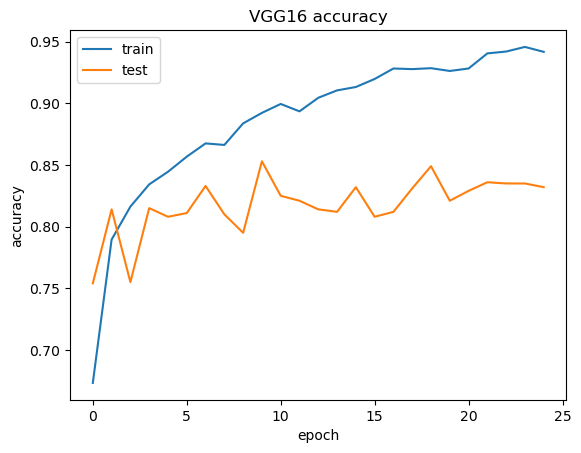

In [7]:
#plot the training and validation accuracy for each epoch, overlaying the training and validation accuracy for each epoch with 2 different colors
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [17]:
#use model on test data
y_pred = model_VGG16.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

32/32 [==============================] - 12s 368ms/step


Text(95.72222222222221, 0.5, 'Truth')

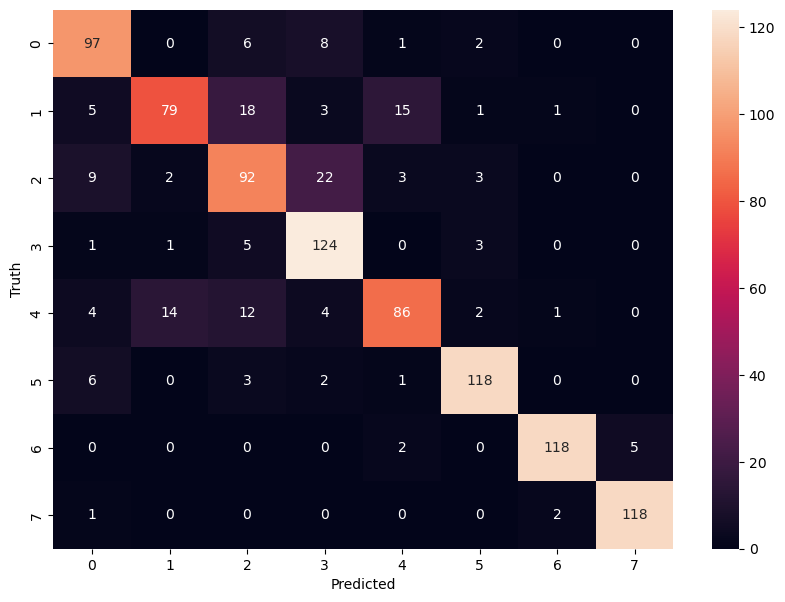

In [18]:
#create a confusion matrix to see how well the model performed on the test data
import matplotlib.pyplot as plt
#Create the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

#plot confusion matrix cm
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [19]:
#plot accuracy of model on test data
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

#plot precision of model on test data
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average='macro')

#plot recall of model on test data
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='macro')

#plot f1 score of model on test data
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

#plot classification report of model on test data
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.85      0.82       114
           2       0.82      0.65      0.72       122
           3       0.68      0.70      0.69       131
           4       0.76      0.93      0.84       134
           5       0.80      0.70      0.74       123
           6       0.91      0.91      0.91       130
           7       0.97      0.94      0.96       125
           8       0.96      0.98      0.97       121

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [20]:
#save the model
model_VGG16.save('model_VGG16.h5')

In [ ]:
#load the model
#from keras.models import load_model
#model_VGG16 = load_model('model_VGG16.h5')

In [11]:
#Train the model with different optmiser (adam)

#Create the model
model_VGG16_2 = models.Sequential()
#adds conv_base to the model (pre-trained VGG16)
model_VGG16_2.add(conv_base)
#adds additional layers to the model
# A Dense classifier with a 9 unit (classification)
model_VGG16_2.add(layers.Flatten())
model_VGG16_2.add(layers.Dense(9, activation='softmax'))

model_VGG16_2.compile(loss='categorical_crossentropy',
                optimizer="adam",
                metrics=['acc'])


In [12]:
#Train the model
history_2 = model_VGG16_2.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/25
125/125 [==============================] - 58s 449ms/step - loss: 1.4321 - acc: 0.5472 - val_loss: 1.0475 - val_acc: 0.6600
Epoch 2/25
125/125 [==============================] - 55s 442ms/step - loss: 0.8868 - acc: 0.7442 - val_loss: 0.8288 - val_acc: 0.7330
Epoch 3/25
125/125 [==============================] - 55s 437ms/step - loss: 0.7404 - acc: 0.7715 - val_loss: 0.7406 - val_acc: 0.7590
Epoch 4/25
125/125 [==============================] - 55s 442ms/step - loss: 0.6673 - acc: 0.7847 - val_loss: 0.6823 - val_acc: 0.7770
Epoch 5/25
125/125 [==============================] - 57s 455ms/step - loss: 0.6191 - acc: 0.7958 - val_loss: 0.6468 - val_acc: 0.7750
Epoch 6/25
125/125 [==============================] - 55s 440ms/step - loss: 0.5852 - acc: 0.8117 - val_loss: 0.6157 - val_acc: 0.7890
Epoch 7/25
125/125 [==============================] - 55s 437ms/step - loss: 0.5578 - acc: 0.8173 - val_loss: 0.5992 - val_acc: 0.7980
Epoch 8/25
125/125 [==============================] - 5

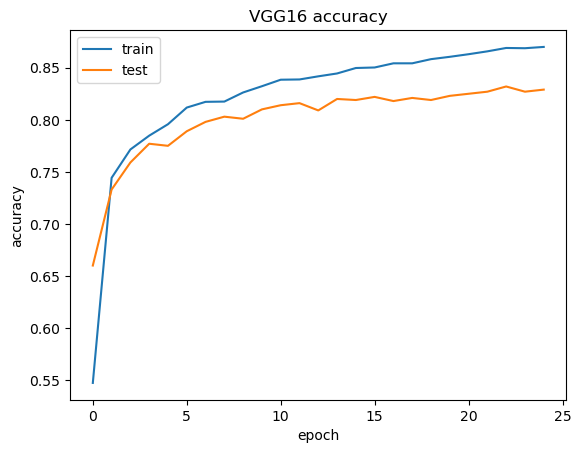

In [13]:
import matplotlib.pyplot as plt
#plot the training and validation accuracy for each epoch, overlaying the training and validation accuracy for each epoch with 2 different colors
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
#Create the VGG16 model with an additional dropout layer to prevent overfitting
model_VGG16_3 = models.Sequential()
#adds conv_base to the model (pre-trained VGG16)
model_VGG16_3.add(conv_base)
#adds additional layers to the model
model_VGG16_3.add(layers.Flatten())
model_VGG16_3.add(layers.Dense(256, activation='relu'))
model_VGG16_3.add(Dropout(0.5))
model_VGG16_3.add(layers.Dense(9, activation='softmax'))

#Compile the model

model_VGG16_3.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=0.01),
                metrics=['acc'])


In [15]:
#Train the model
history_3 = model_VGG16_3.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/25
125/125 [==============================] - 69s 529ms/step - loss: 1.1412 - acc: 0.6410 - val_loss: 0.6743 - val_acc: 0.7540
Epoch 2/25
125/125 [==============================] - 68s 549ms/step - loss: 0.7853 - acc: 0.7322 - val_loss: 0.6003 - val_acc: 0.7960
Epoch 3/25
125/125 [==============================] - 61s 487ms/step - loss: 0.7044 - acc: 0.7650 - val_loss: 0.5497 - val_acc: 0.8000
Epoch 4/25
125/125 [==============================] - 61s 489ms/step - loss: 0.7065 - acc: 0.7650 - val_loss: 0.6027 - val_acc: 0.7840
Epoch 5/25
125/125 [==============================] - 58s 463ms/step - loss: 0.6593 - acc: 0.7812 - val_loss: 0.5895 - val_acc: 0.8040
Epoch 6/25
125/125 [==============================] - 58s 466ms/step - loss: 0.6505 - acc: 0.7835 - val_loss: 0.5644 - val_acc: 0.8110
Epoch 7/25
125/125 [==============================] - 55s 441ms/step - loss: 0.6664 - acc: 0.7840 - val_loss: 0.6610 - val_acc: 0.8060
Epoch 8/25
125/125 [==============================] - 6

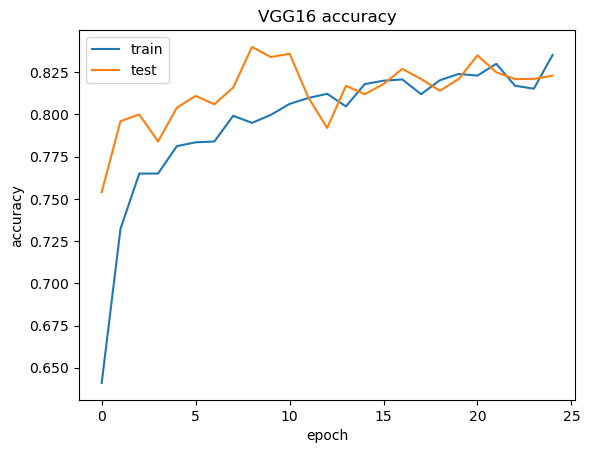

In [16]:
import matplotlib.pyplot as plt
#plot the training and validation accuracy for each epoch, overlaying the training and validation accuracy for each epoch with 2 different colors
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])
plt.title('VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()